In [1]:
freq = 15

In [2]:
import codigo
from codigo import utils
from codigo import model_LSTM
from codigo import model_utils
from cg_ega.cg_ega import CG_EGA

In [3]:
import pandas as pd
import numpy as np
pd.set_option('mode.chained_assignment',None)
import matplotlib.pyplot as plt
import seaborn as sns
import math

%matplotlib inline

In [4]:
import tensorflow as tf
from tensorflow import keras

In [5]:
with open('dataset/generado/dataset15min/array_Xtest.npy', 'rb') as f:
    array_Xtest = np.load(f)

In [6]:
len(array_Xtest)

88632

In [7]:
with open('dataset/generado/dataset15min/array_Ytest.npy', 'rb') as f:
    array_Ytest = np.load(f)

In [8]:
len(array_Ytest)

88632

In [9]:
model = keras.models.load_model('modelos/modeloGeneral_v1.h5')

In [10]:
from pickle import load
scalerHours = load(open('dataset/generado/scalerHours.scaler', 'rb'))
scalerMin = load(open('dataset/generado/scalerMin.scaler', 'rb'))
scalerGlucosa = load(open('dataset/generado/scalerGlucosa.scaler', 'rb'))
scalerPodId = load(open('dataset/generado/scalerPodId.scaler', 'rb'))
scalerLevelId = load(open('dataset/generado/scalerLevelId.scaler', 'rb'))

# Predicción de todo el conjunto de pruebas generales

In [11]:
len(array_Ytest)

88632

2770/2770 [==============================] - 27s 10ms/step


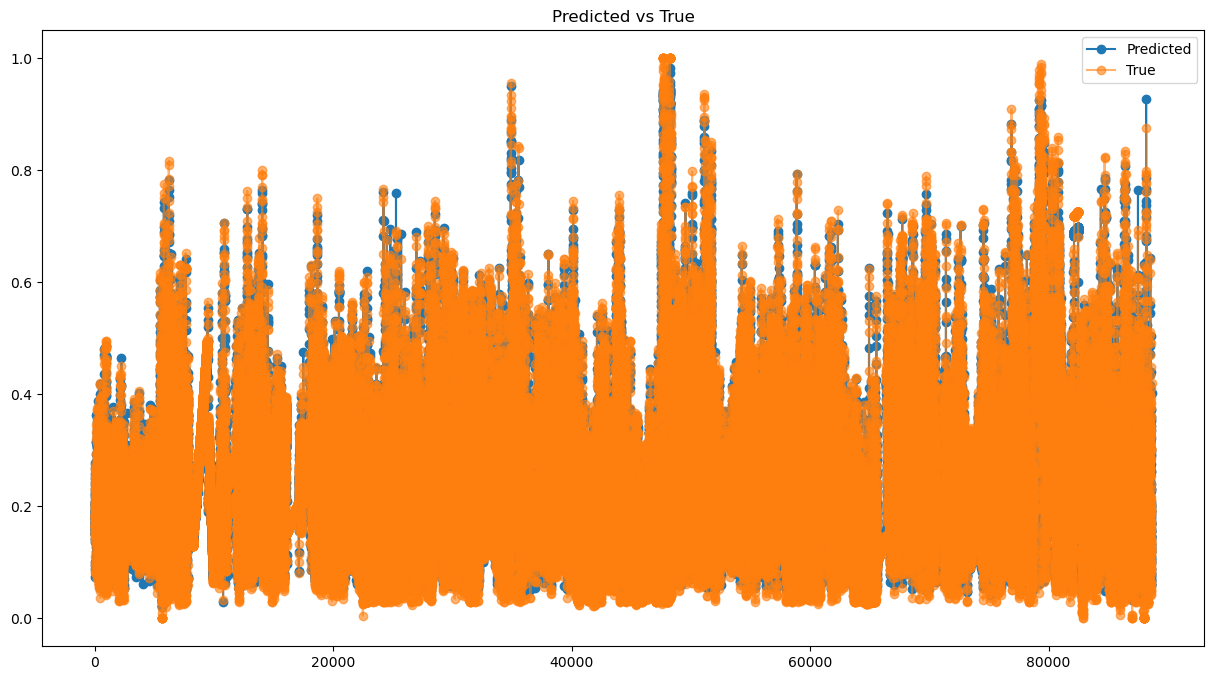

In [12]:
yhat = model.predict(array_Xtest)
model_utils.plotPredicted(yhat,array_Ytest)

In [13]:
model_utils.forecast_accuracy(yhat,array_Ytest)

{'mae': 0.014154667296007303,
 'mse': 0.01923064587869538,
 'rmse': 0.0003698177409117836}

In [14]:
yhat_scaled=scalerGlucosa.inverse_transform(yhat)
yhat_df = pd.DataFrame(yhat_scaled, columns=['Glucose level'])
yhat_df

,Glucose level
0,112.238525
1,123.463898
2,122.750999
3,113.375816
4,113.741432
...,...
88627,133.107635
88628,161.004501
88629,198.201782
88630,194.380203


In [15]:
array_Ytest_scaled=scalerGlucosa.inverse_transform(array_Ytest)
array_Ytest_df = pd.DataFrame(array_Ytest_scaled, columns=['Glucose level'])
array_Ytest_df

,Glucose level
0,116.0
1,122.0
2,117.0
3,112.0
4,115.0
...,...
88627,137.0
88628,177.0
88629,198.0
88630,216.0


In [60]:
dfPlot=pd.DataFrame()
dfPlot['y_true']=array_Ytest_df['Glucose level']
dfPlot['y_pred']=yhat_df['Glucose level']
dfPlot.index=pd.date_range("2023-01-01", periods=len(array_Ytest), freq="15min")
dfPlot

,y_true,y_pred
2023-01-01 00:00:00,116.0,112.238525
2023-01-01 00:15:00,122.0,123.463898
2023-01-01 00:30:00,117.0,122.750999
2023-01-01 00:45:00,112.0,113.375816
2023-01-01 01:00:00,115.0,113.741432
...,...,...
2025-07-12 04:45:00,137.0,133.107635
2025-07-12 05:00:00,177.0,161.004501
2025-07-12 05:15:00,198.0,198.201782
2025-07-12 05:30:00,216.0,194.380203


AP, BE, EP: (0.984407261567623, 0.013460301700308019, 0.0021324367320689147)


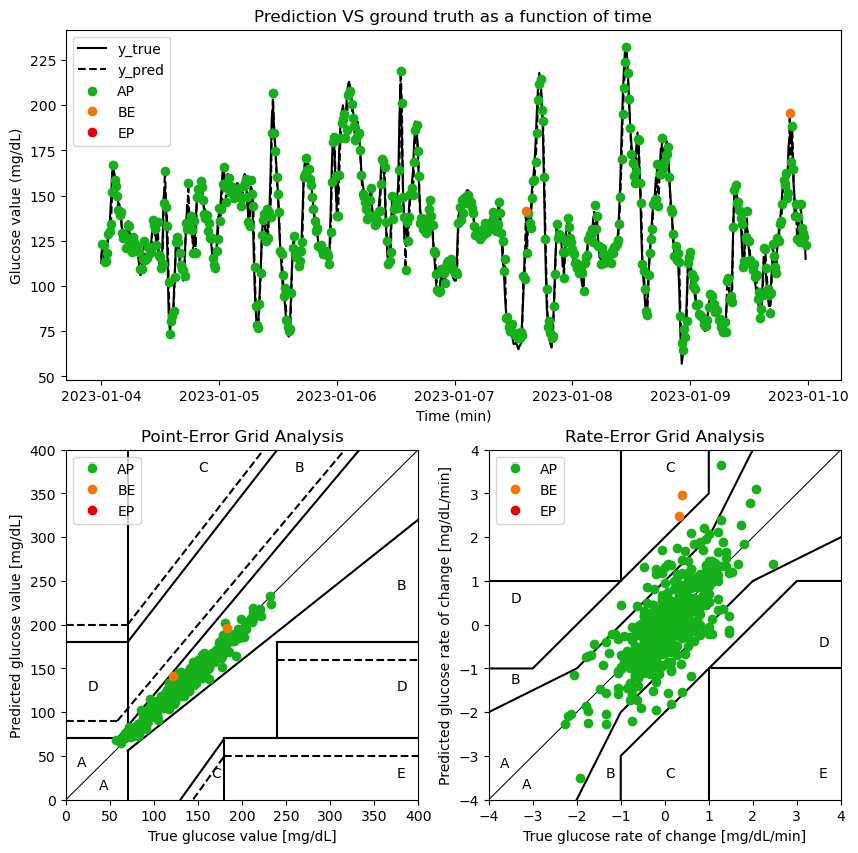

In [17]:
cg_ega = CG_EGA(dfPlot, 15)
print("AP, BE, EP:", cg_ega.reduced())
cg_ega.plot(day=5)

In [18]:
cg_ega.per_sample()

,datetime,y_true,y_pred,dy_true,dy_pred,CG_EGA,P_EGA,R_EGA
0,2023-01-04 00:00:00,116.0,112.238525,NaN,NaN,NaN,NaN,NaN
1,2023-01-04 00:15:00,122.0,123.463898,0.400000,0.748358,AP,A,A
2,2023-01-04 00:30:00,117.0,122.750999,-0.333333,-0.047527,AP,A,A
3,2023-01-04 00:45:00,112.0,113.375816,-0.333333,-0.625012,AP,A,A
4,2023-01-04 01:00:00,115.0,113.741432,0.200000,0.024374,AP,A,A
...,...,...,...,...,...,...,...,...
88627,2025-07-15 04:45:00,137.0,133.107635,2.333333,3.107563,AP,A,A
88628,2025-07-15 05:00:00,177.0,161.004501,2.666667,1.859791,AP,A,A
88629,2025-07-15 05:15:00,198.0,198.201782,1.400000,2.479819,AP,A,A
88630,2025-07-15 05:30:00,216.0,194.380203,1.200000,-0.254772,AP,A,B


# Predicción a 30 min del conjunto de pruebas generales

In [19]:
lenHorizonte=2
XTest=[]
YTest=[]
for i in range(lenHorizonte):
    XTest.append(array_Xtest[i]) 
    YTest.append(array_Ytest[i]) 
XTest=np.reshape(XTest, (lenHorizonte, array_Xtest.shape[1],array_Xtest.shape[2]))

df_YTest = pd.DataFrame(YTest, columns=['Glucose level True'])

YTest_scaled=scalerGlucosa.inverse_transform(YTest)
df_YTest_scaled = pd.DataFrame(YTest_scaled, columns=['Glucose level True']) 

In [20]:
yhat = model.predict(XTest)
df_glucose = pd.DataFrame(yhat, columns=['Glucose level Predict'])
df_glucose['Glucose level True']=df_YTest['Glucose level True']
df_glucose.head()

1/1 [==============================] - 0s 37ms/step


,Glucose level Predict,Glucose level True
0,0.157040,0.165217
1,0.181443,0.178261


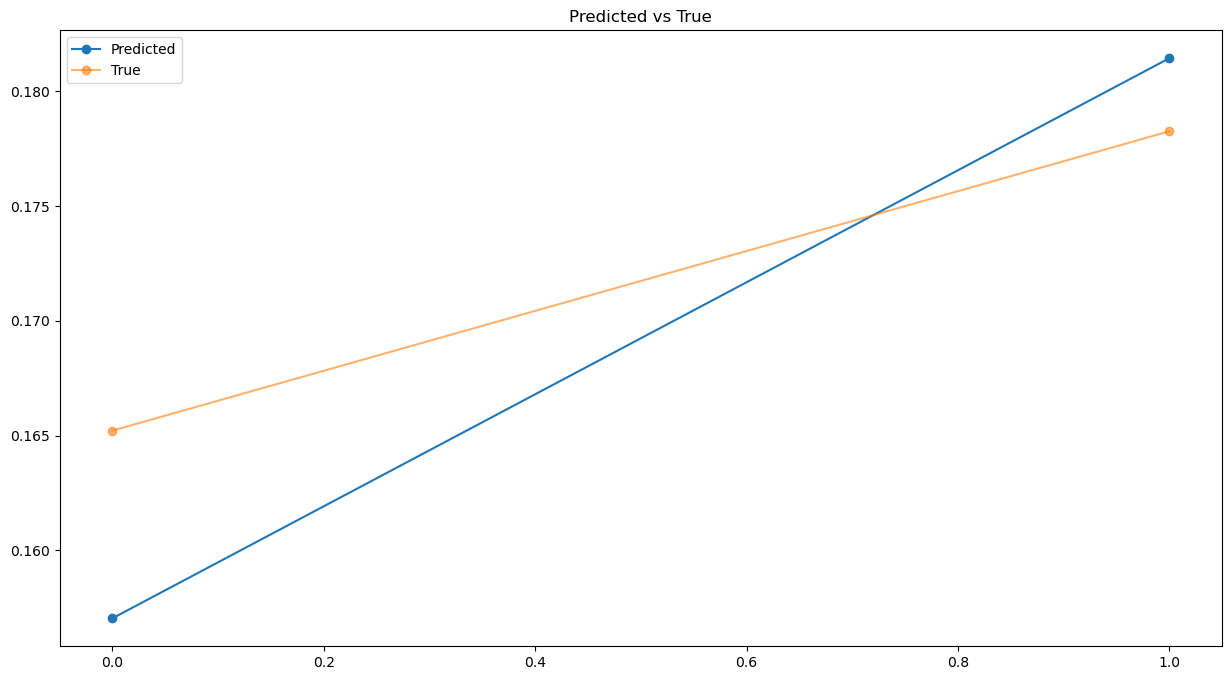

{'mae': 0.005679733986439894,
 'mse': 0.006204541131228213,
 'rmse': 3.849633064910268e-05}

In [21]:
model_utils.plotPredicted(yhat,YTest)
model_utils.forecast_accuracy(yhat,YTest)

In [22]:
yhat_scaled=scalerGlucosa.inverse_transform(yhat)
df_glucose = pd.DataFrame(yhat_scaled, columns=['Glucose level Predict'])
df_glucose['Glucose level True']=df_YTest_scaled['Glucose level True']
df_glucose.head()

,Glucose level Predict,Glucose level True
0,112.238518,116.0
1,123.463882,122.0


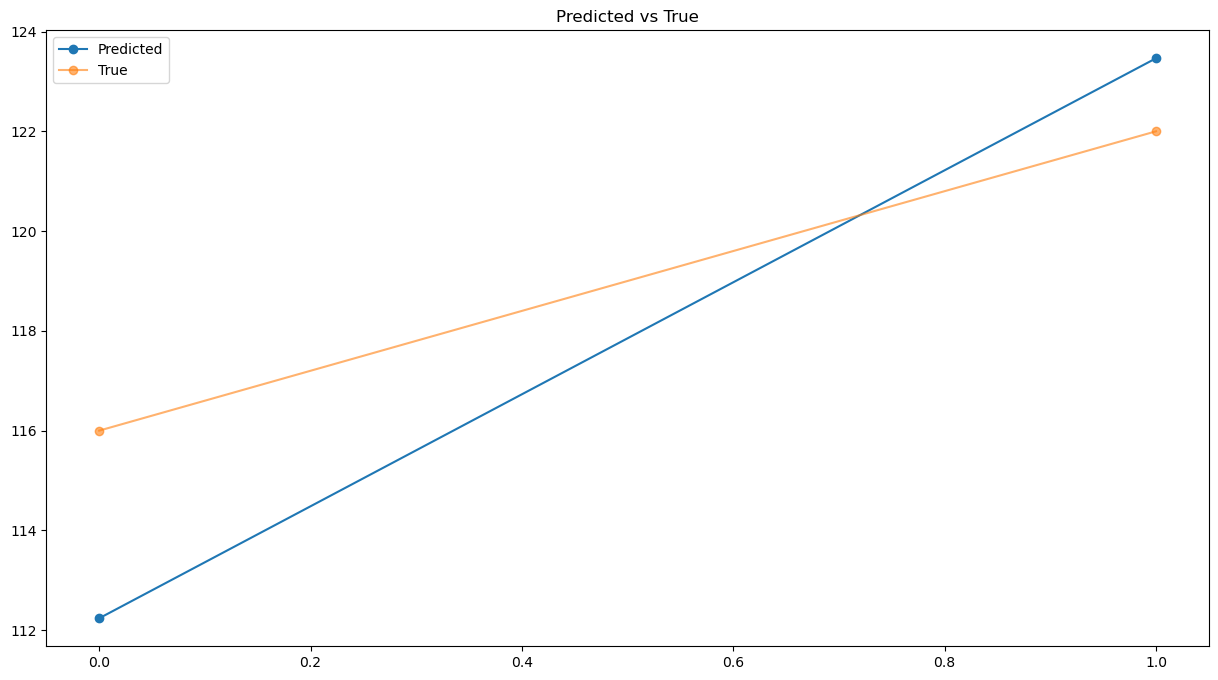

{'mae': 2.6126823425292827,
 'mse': 2.8540935907159515,
 'rmse': 8.145850224565873}

In [23]:
model_utils.plotPredicted(yhat_scaled,YTest_scaled)
model_utils.forecast_accuracy(yhat_scaled,YTest_scaled)

# Predicción sobre predicción a 30 min del conjunto de pruebas generales

In [24]:
yhat=model_utils.predictionOverPrediction(XTest,model)
df_yhat = pd.DataFrame(yhat, columns=['Glucose level Predict'])
df_yhat.head()

df_glucose = pd.DataFrame(yhat, columns=['Glucose level Predict'])
df_glucose['Glucose level True']=df_YTest['Glucose level True']
df_glucose.head()

1/1 [==============================] - 0s 25ms/step


,Glucose level Predict,Glucose level True
0,0.157040,0.165217
1,0.167929,0.178261


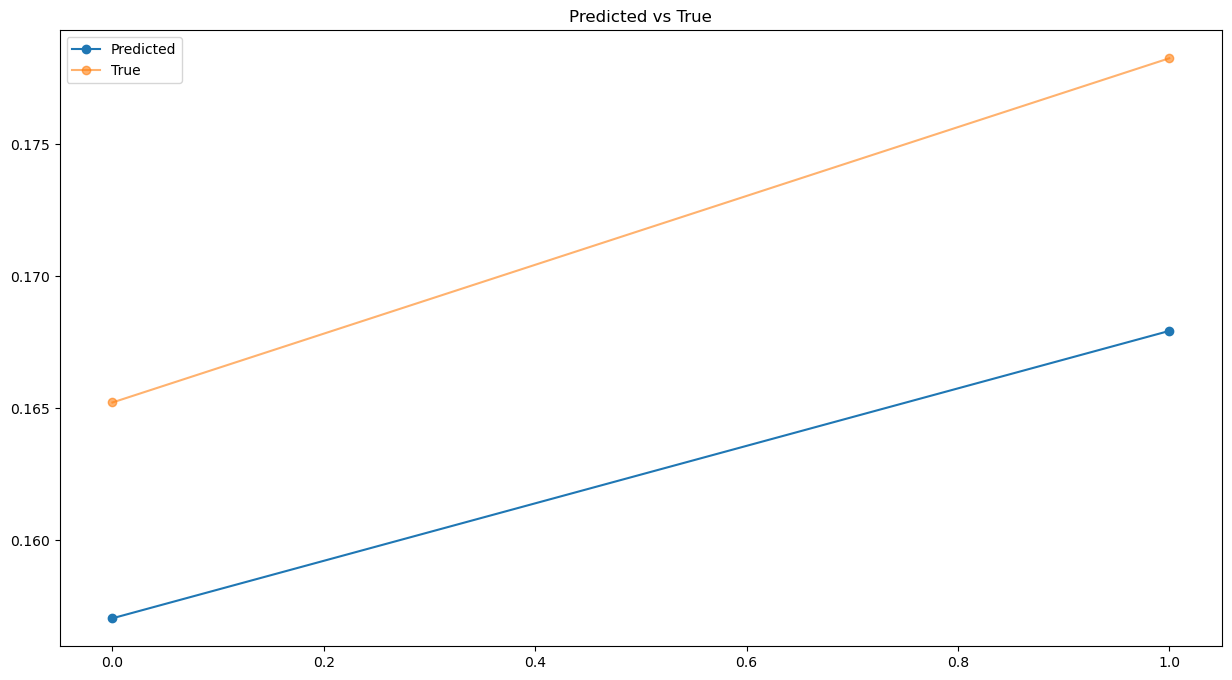

{'mae': 0.009254365381987206,
 'mse': 0.00931685190989434,
 'rmse': 8.680372951090179e-05}

In [25]:
model_utils.plotPredicted(yhat,YTest)
model_utils.forecast_accuracy(yhat,YTest)

In [26]:
yhat_scaled=scalerGlucosa.inverse_transform(df_yhat) 

df_glucose = pd.DataFrame(yhat_scaled, columns=['Glucose level Predict'])
df_glucose['Glucose level True']=df_YTest_scaled['Glucose level True']
df_glucose.head()

,Glucose level Predict,Glucose level True
0,112.238518,116.0
1,117.247467,122.0


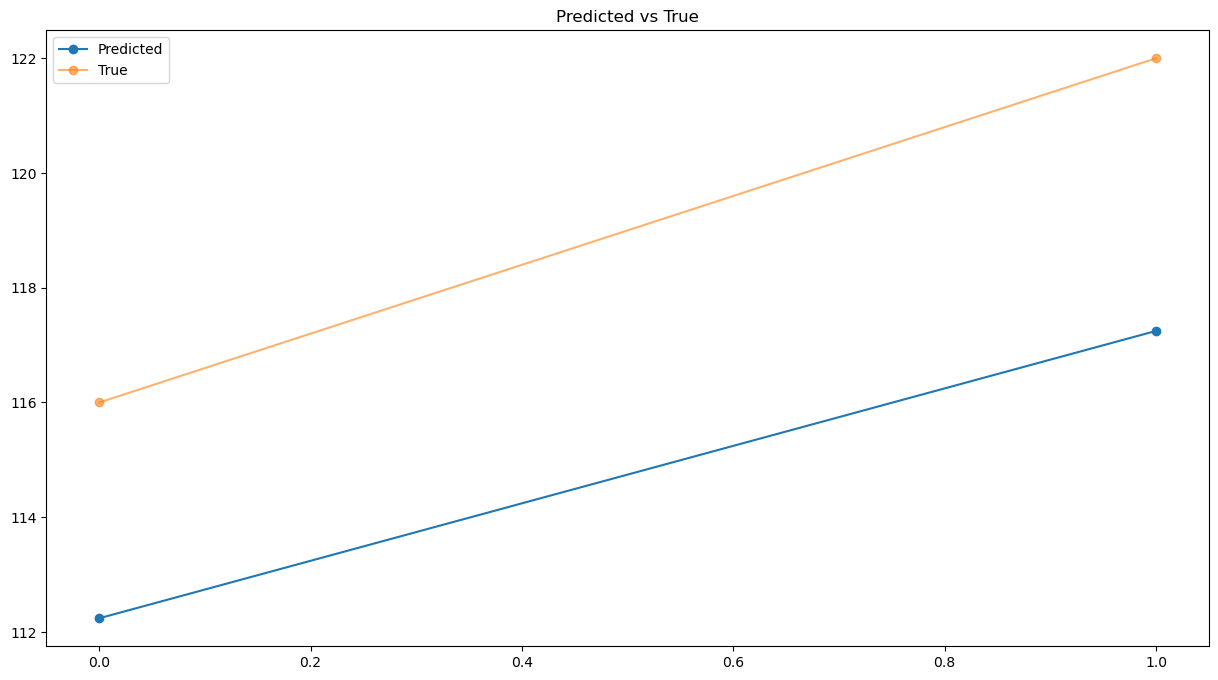

{'mae': 4.257007598876953,
 'mse': 4.285750701966427,
 'rmse': 18.367659079405726}

In [27]:
model_utils.plotPredicted(yhat_scaled,YTest_scaled)
model_utils.forecast_accuracy(yhat_scaled,YTest_scaled)

# Predicción del conjunto eventos del paciente 1

In [28]:
with open('dataset/generado/paciente1/eventos_X.npy', 'rb') as f:
    X = np.load(f) 

In [29]:
with open('dataset/generado/paciente1/eventos_Y.npy', 'rb') as f:
    Y = np.load(f) 

In [30]:
len(X)

25

In [31]:
len(Y)

25

In [32]:
df_Y = pd.DataFrame(Y, columns=['Glucose level True'])

Y_scaled=scalerGlucosa.inverse_transform(Y)
df_Y_scaled = pd.DataFrame(Y_scaled, columns=['Glucose level True']) 

In [33]:
yhat = model.predict(X)
df_glucose = pd.DataFrame(yhat, columns=['Glucose level Predict'])
df_glucose['Glucose level True']=df_Y['Glucose level True']
df_glucose.head()

1/1 [==============================] - 0s 33ms/step


,Glucose level Predict,Glucose level True
0,0.135798,0.130435
1,0.315121,0.328261
2,0.326523,0.345652
3,0.090320,0.086957
4,0.265319,0.245652


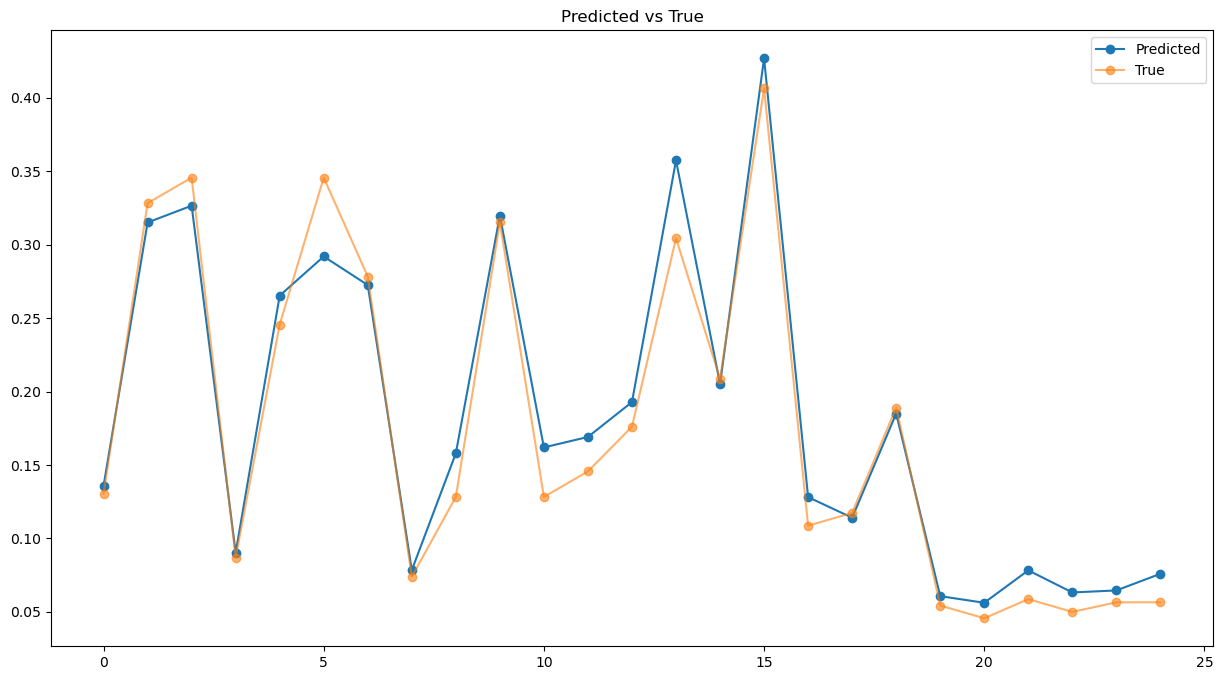

{'mae': 0.01655175069622371,
 'mse': 0.0215119755567243,
 'rmse': 0.0004627650923531038}

In [34]:
model_utils.plotPredicted(yhat,Y)
model_utils.forecast_accuracy(yhat,Y)

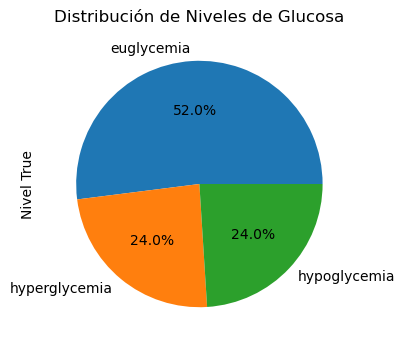

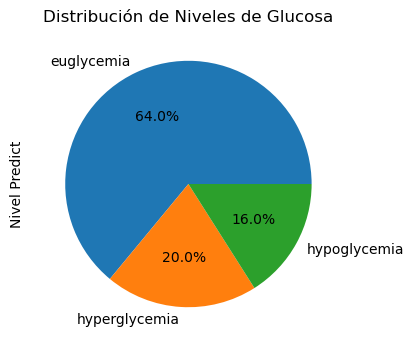

,Glucose level Predict,Nivel Predict,Glucose level True,Nivel True
0,102.466980,euglycemia,100.0,euglycemia
1,184.955612,hyperglycemia,191.0,hyperglycemia
2,190.200775,hyperglycemia,199.0,hyperglycemia
3,81.547096,euglycemia,80.0,euglycemia
4,162.046600,euglycemia,153.0,euglycemia


In [35]:
yhat_scaled=scalerGlucosa.inverse_transform(yhat)
df_glucose = pd.DataFrame(yhat_scaled, columns=['Glucose level Predict'])
df_glucose['Nivel Predict'] = df_glucose['Glucose level Predict'].apply(utils.label_LevelBG) 

df_glucose['Glucose level True']=df_Y_scaled['Glucose level True']
df_glucose['Nivel True'] = df_Y_scaled['Glucose level True'].apply(utils.label_LevelBG) 
df_glucose['Nivel True'].value_counts().plot.pie(title='Distribución de Niveles de Glucosa',y='level_label',legend=False,autopct='%1.1f%%',figsize=(10, 4))
plt.show()

df_glucose['Nivel Predict'].value_counts().plot.pie(title='Distribución de Niveles de Glucosa',y='level_label',legend=False,autopct='%1.1f%%',figsize=(10, 4))
plt.show()

df_glucose.head()


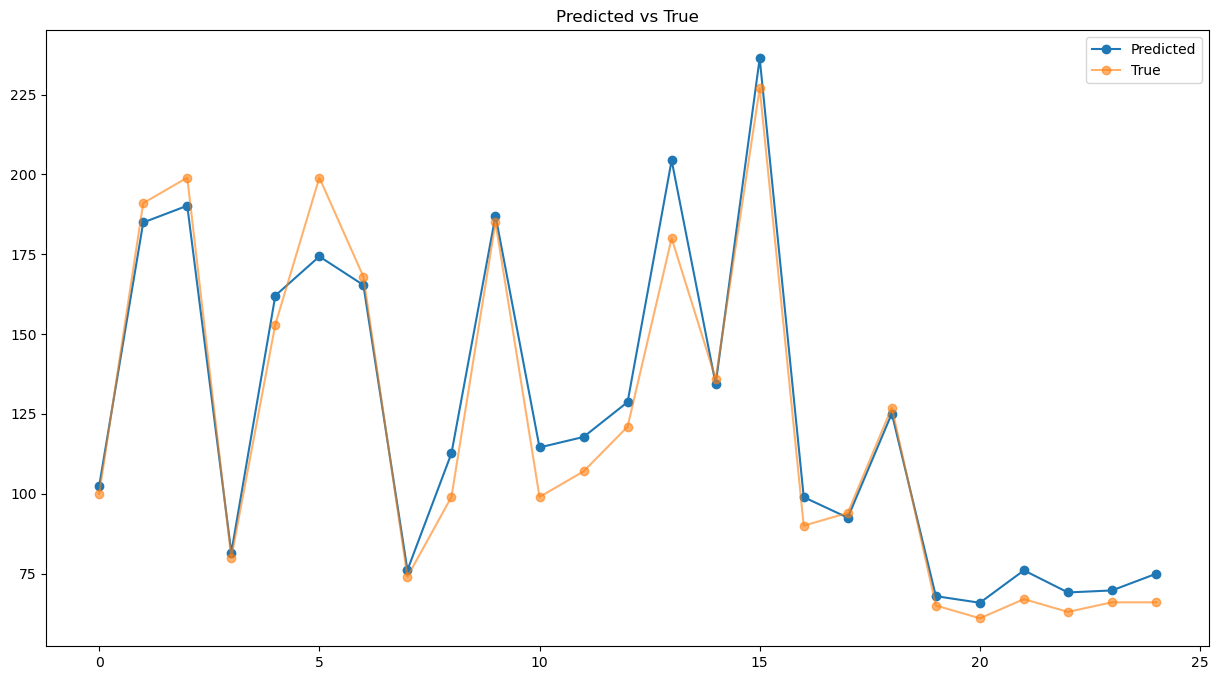

{'mae': 7.613804321289063, 'mse': 9.895508601027126, 'rmse': 97.92109047300183}

In [36]:
model_utils.plotPredicted(yhat_scaled,Y_scaled)
model_utils.forecast_accuracy(yhat_scaled,Y_scaled)

# Predicción del conjunto eventos del paciente 2

In [37]:
with open('dataset/generado/paciente2/eventos_X.npy', 'rb') as f:
    X = np.load(f) 

In [38]:
with open('dataset/generado/paciente2/eventos_Y.npy', 'rb') as f:
    Y = np.load(f) 

In [39]:
len(X)

25

In [40]:
len(Y)

25

In [41]:
df_Y = pd.DataFrame(Y, columns=['Glucose level True'])

Y_scaled=scalerGlucosa.inverse_transform(Y)
df_Y_scaled = pd.DataFrame(Y_scaled, columns=['Glucose level True']) 

In [42]:
yhat = model.predict(X)
df_glucose = pd.DataFrame(yhat, columns=['Glucose level Predict'])
df_glucose['Glucose level True']=df_Y['Glucose level True']
df_glucose.head()

1/1 [==============================] - 0s 29ms/step


,Glucose level Predict,Glucose level True
0,0.135798,0.130435
1,0.315121,0.328261
2,0.326523,0.345652
3,0.090320,0.086957
4,0.265319,0.245652


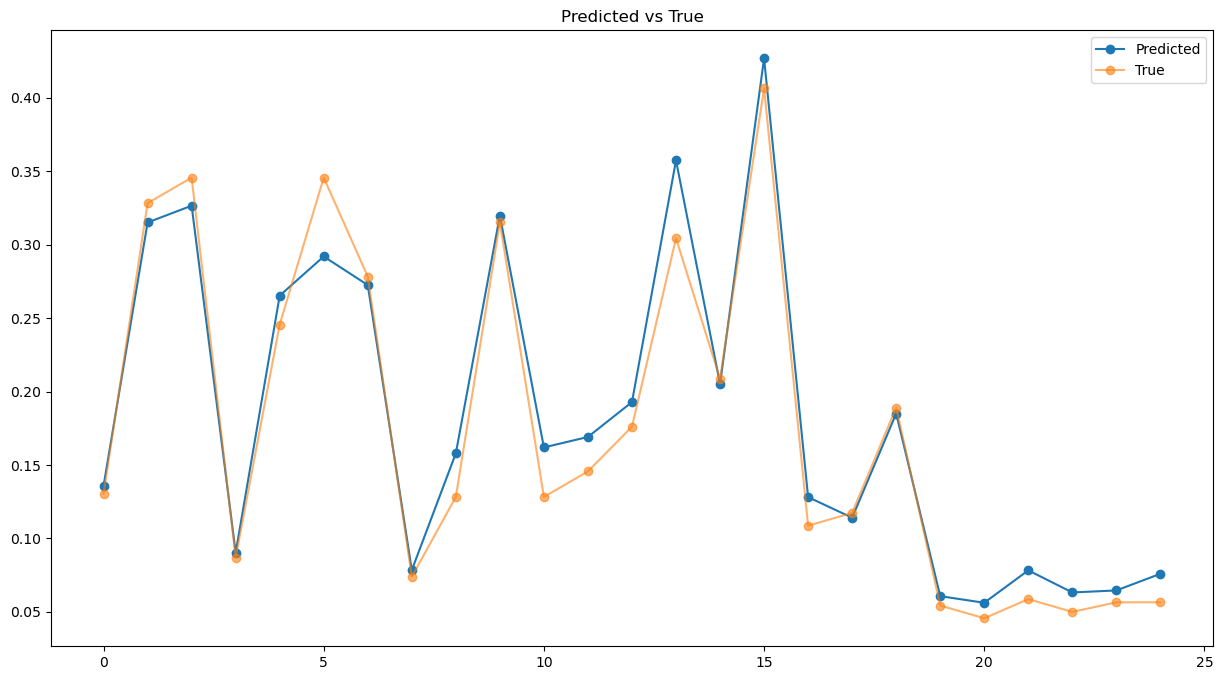

{'mae': 0.01655175069622371,
 'mse': 0.0215119755567243,
 'rmse': 0.0004627650923531038}

In [43]:
model_utils.plotPredicted(yhat,Y)
model_utils.forecast_accuracy(yhat,Y)

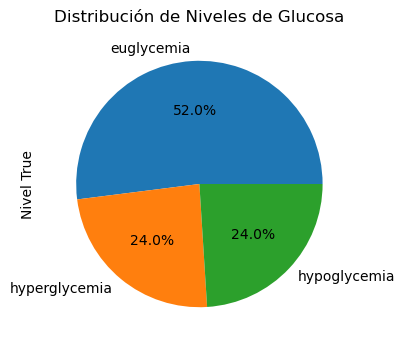

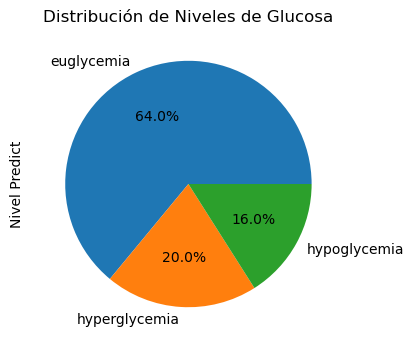

,Glucose level Predict,Nivel Predict,Glucose level True,Nivel True
0,102.466980,euglycemia,100.0,euglycemia
1,184.955612,hyperglycemia,191.0,hyperglycemia
2,190.200775,hyperglycemia,199.0,hyperglycemia
3,81.547096,euglycemia,80.0,euglycemia
4,162.046600,euglycemia,153.0,euglycemia


In [44]:
yhat_scaled=scalerGlucosa.inverse_transform(yhat)
df_glucose = pd.DataFrame(yhat_scaled, columns=['Glucose level Predict'])
df_glucose['Nivel Predict'] = df_glucose['Glucose level Predict'].apply(utils.label_LevelBG) 

df_glucose['Glucose level True']=df_Y_scaled['Glucose level True']
df_glucose['Nivel True'] = df_Y_scaled['Glucose level True'].apply(utils.label_LevelBG) 
df_glucose['Nivel True'].value_counts().plot.pie(title='Distribución de Niveles de Glucosa',y='level_label',legend=False,autopct='%1.1f%%',figsize=(10, 4))
plt.show()

df_glucose['Nivel Predict'].value_counts().plot.pie(title='Distribución de Niveles de Glucosa',y='level_label',legend=False,autopct='%1.1f%%',figsize=(10, 4))
plt.show()

df_glucose.head()


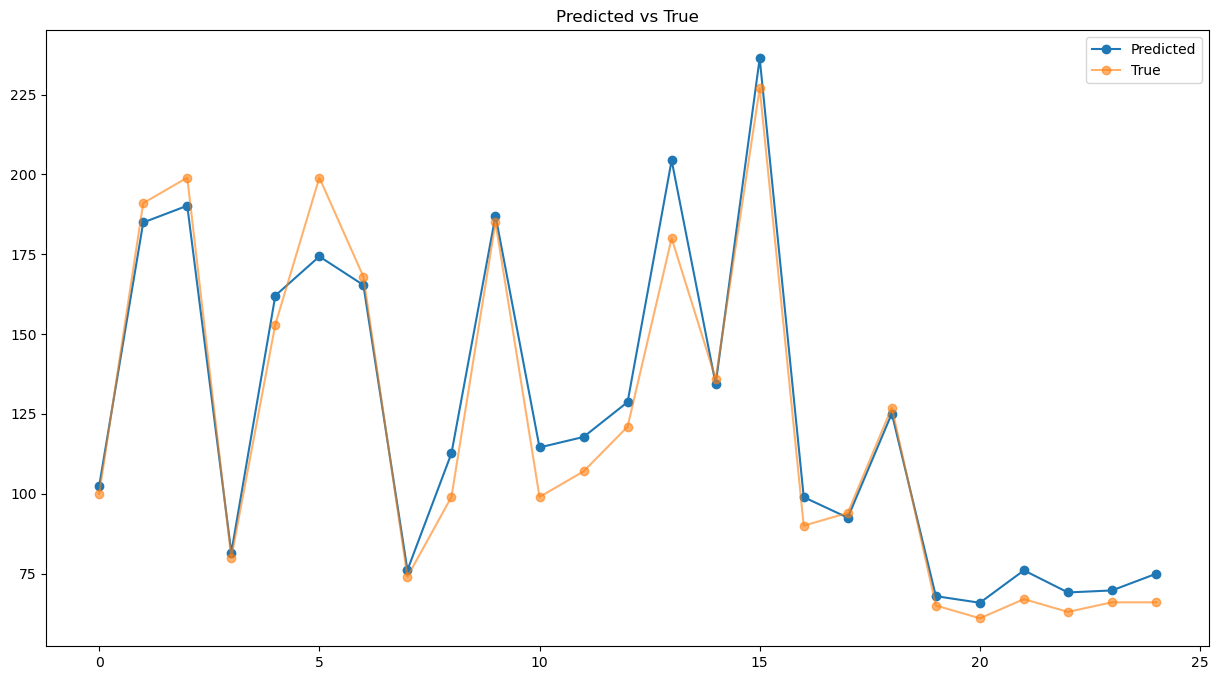

{'mae': 7.613804321289063, 'mse': 9.895508601027126, 'rmse': 97.92109047300183}

In [45]:
model_utils.plotPredicted(yhat_scaled,Y_scaled)
model_utils.forecast_accuracy(yhat_scaled,Y_scaled)

# Predicción del conjunto eventos del paciente 3

In [46]:
with open('dataset/generado/paciente3/eventos_X.npy', 'rb') as f:
    X = np.load(f) 

In [47]:
with open('dataset/generado/paciente3/eventos_Y.npy', 'rb') as f:
    Y = np.load(f) 

In [48]:
len(X)

24

In [49]:
len(Y)

24

In [50]:
df_Y = pd.DataFrame(Y, columns=['Glucose level True'])

Y_scaled=scalerGlucosa.inverse_transform(Y)
df_Y_scaled = pd.DataFrame(Y_scaled, columns=['Glucose level True'])

In [51]:
yhat = model.predict(X)
df_glucose = pd.DataFrame(yhat, columns=['Glucose level Predict'])
df_glucose['Glucose level True']=df_Y['Glucose level True']
df_glucose.head()

1/1 [==============================] - 0s 28ms/step


,Glucose level Predict,Glucose level True
0,0.052696,0.030435
1,0.167655,0.165217
2,0.192287,0.208696
3,0.050346,0.028261
4,0.224794,0.223913


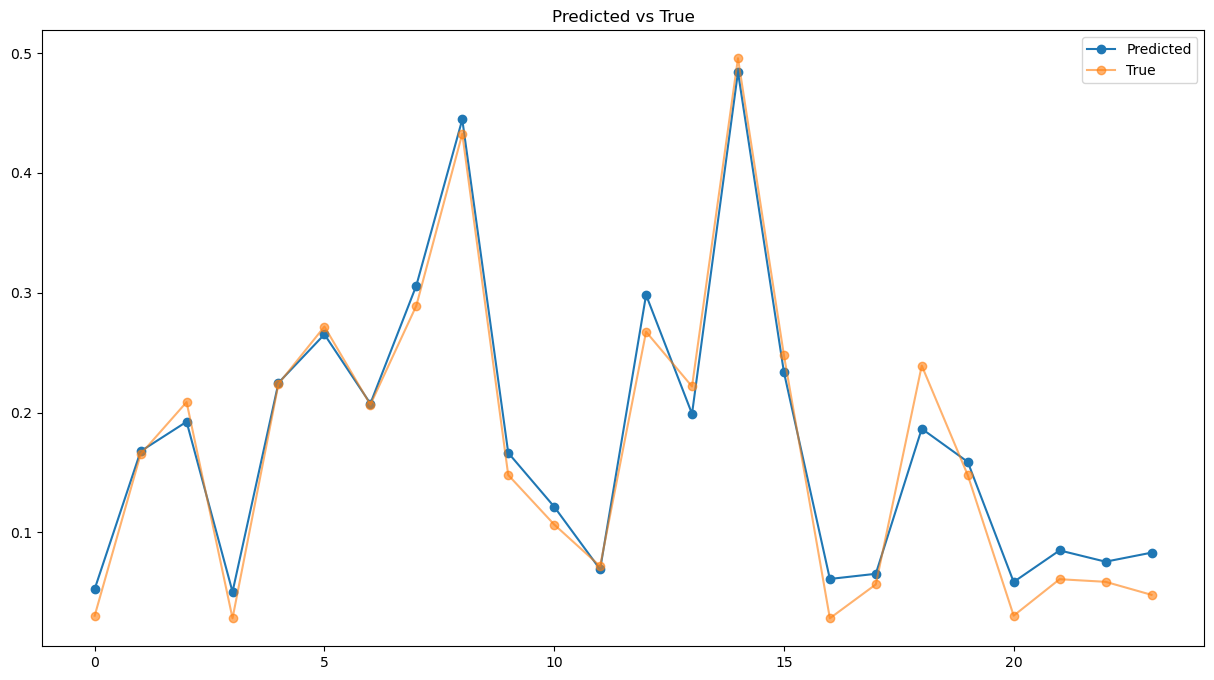

{'mae': 0.017711532582947307,
 'mse': 0.021448012814260745,
 'rmse': 0.0004600172536806931}

In [52]:
model_utils.plotPredicted(yhat,Y)
model_utils.forecast_accuracy(yhat,Y)

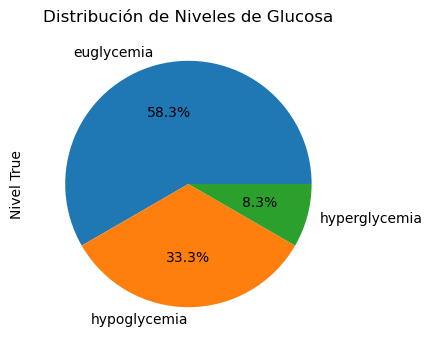

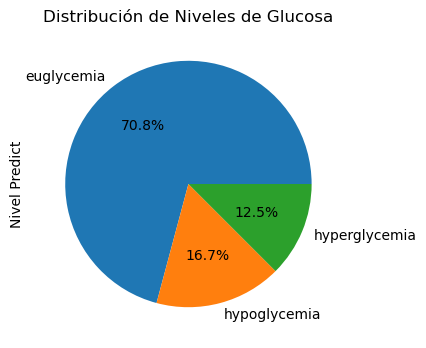

,Glucose level Predict,Nivel Predict,Glucose level True,Nivel True
0,64.240288,hypoglycemia,54.0,hypoglycemia
1,117.121422,euglycemia,116.0,euglycemia
2,128.452118,euglycemia,136.0,euglycemia
3,63.159054,hypoglycemia,53.0,hypoglycemia
4,143.405396,euglycemia,143.0,euglycemia


In [53]:
yhat_scaled=scalerGlucosa.inverse_transform(yhat)
df_glucose = pd.DataFrame(yhat_scaled, columns=['Glucose level Predict'])
df_glucose['Nivel Predict'] = df_glucose['Glucose level Predict'].apply(utils.label_LevelBG) 

df_glucose['Glucose level True']=df_Y_scaled['Glucose level True']
df_glucose['Nivel True'] = df_Y_scaled['Glucose level True'].apply(utils.label_LevelBG) 
df_glucose['Nivel True'].value_counts().plot.pie(title='Distribución de Niveles de Glucosa',y='level_label',legend=False,autopct='%1.1f%%',figsize=(10, 4))
plt.show()

df_glucose['Nivel Predict'].value_counts().plot.pie(title='Distribución de Niveles de Glucosa',y='level_label',legend=False,autopct='%1.1f%%',figsize=(10, 4))
plt.show()

df_glucose.head()



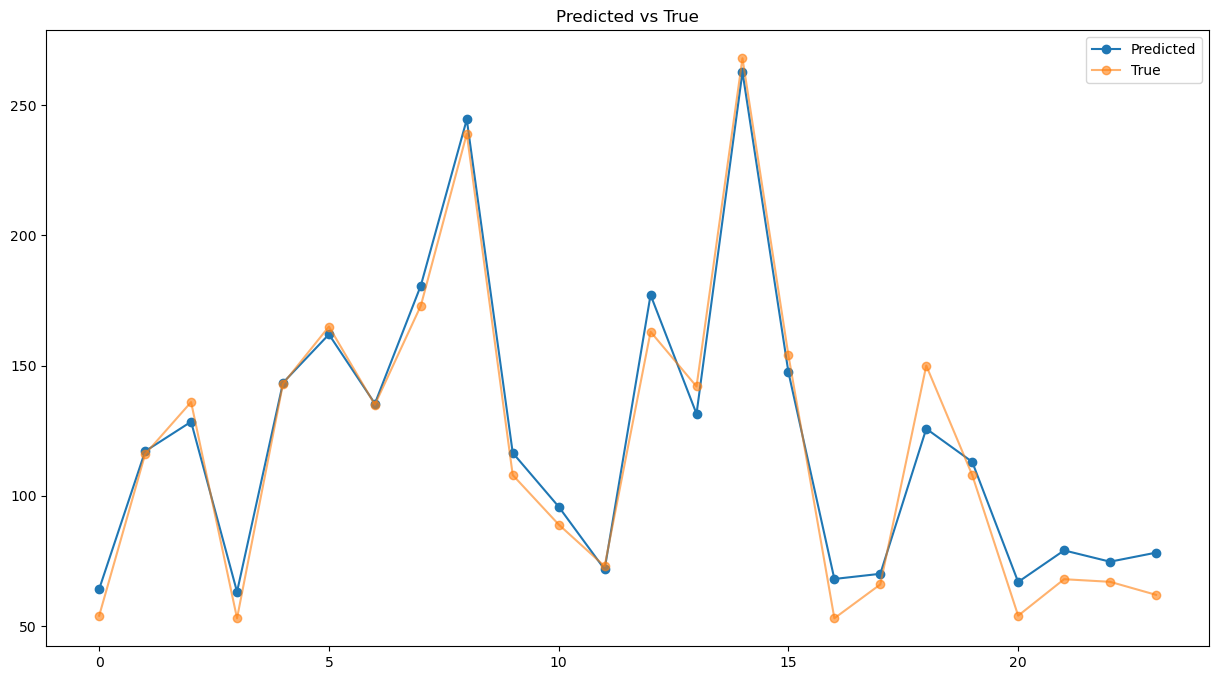

{'mae': 8.147304693857828, 'mse': 9.866085518681334, 'rmse': 97.33964346193352}

In [54]:
model_utils.plotPredicted(yhat_scaled,Y_scaled)
model_utils.forecast_accuracy(yhat_scaled,Y_scaled)

In [55]:
import matplotlib.pyplot as plt


#This function takes in the reference values and the prediction values as lists and returns a list with each index corresponding to the total number
#of points within that zone (0=A, 1=B, 2=C, 3=D, 4=E) and the plot
def clarke_error_grid(ref_values, pred_values, title_string):

    #Checking to see if the lengths of the reference and prediction arrays are the same
    assert (len(ref_values) == len(pred_values)), "Unequal number of values (reference : {}) (prediction : {}).".format(len(ref_values), len(pred_values))

    #Checks to see if the values are within the normal physiological range, otherwise it gives a warning
    if max(ref_values) > 400 or max(pred_values) > 400:
        print("Input Warning: the maximum reference value {} or the maximum prediction value {} exceeds the normal physiological range of glucose (<400 mg/dl).".format(max(ref_values), max(pred_values)))
    if min(ref_values) < 0 or min(pred_values) < 0:
        print("Input Warning: the minimum reference value {} or the minimum prediction value {} is less than 0 mg/dl.".format(min(ref_values),  min(pred_values)))

    #Clear plot
    plt.clf()

    #Set up plot
    plt.scatter(ref_values, pred_values, marker='o', color='black', s=8)
    plt.title(title_string + " Clarke Error Grid")
    plt.xlabel("Reference Concentration (mg/dl)")
    plt.ylabel("Prediction Concentration (mg/dl)")
    plt.xticks([0, 50, 100, 150, 200, 250, 300, 350, 400])
    plt.yticks([0, 50, 100, 150, 200, 250, 300, 350, 400])
    plt.gca().set_facecolor('white')

    #Set axes lengths
    plt.gca().set_xlim([0, 400])
    plt.gca().set_ylim([0, 400])
    plt.gca().set_aspect((400)/(400))

    #Plot zone lines
    plt.plot([0,400], [0,400], ':', c='black')                      #Theoretical 45 regression line
    plt.plot([0, 175/3], [70, 70], '-', c='black')
    #plt.plot([175/3, 320], [70, 400], '-', c='black')
    plt.plot([175/3, 400/1.2], [70, 400], '-', c='black')           #Replace 320 with 400/1.2 because 100*(400 - 400/1.2)/(400/1.2) =  20% error
    plt.plot([70, 70], [84, 400],'-', c='black')
    plt.plot([0, 70], [180, 180], '-', c='black')
    plt.plot([70, 290],[180, 400],'-', c='black')
    # plt.plot([70, 70], [0, 175/3], '-', c='black')
    plt.plot([70, 70], [0, 56], '-', c='black')                     #Replace 175.3 with 56 because 100*abs(56-70)/70) = 20% error
    # plt.plot([70, 400],[175/3, 320],'-', c='black')
    plt.plot([70, 400], [56, 320],'-', c='black')
    plt.plot([180, 180], [0, 70], '-', c='black')
    plt.plot([180, 400], [70, 70], '-', c='black')
    plt.plot([240, 240], [70, 180],'-', c='black')
    plt.plot([240, 400], [180, 180], '-', c='black')
    plt.plot([130, 180], [0, 70], '-', c='black')

    #Add zone titles
    plt.text(30, 15, "A", fontsize=15)
    plt.text(370, 260, "B", fontsize=15)
    plt.text(280, 370, "B", fontsize=15)
    plt.text(160, 370, "C", fontsize=15)
    plt.text(160, 15, "C", fontsize=15)
    plt.text(30, 140, "D", fontsize=15)
    plt.text(370, 120, "D", fontsize=15)
    plt.text(30, 370, "E", fontsize=15)
    plt.text(370, 15, "E", fontsize=15)

    #Statistics from the data
    zone = [0] * 5
    for i in range(len(ref_values)):
        if (ref_values[i] <= 70 and pred_values[i] <= 70) or (pred_values[i] <= 1.2*ref_values[i] and pred_values[i] >= 0.8*ref_values[i]):
            zone[0] += 1    #Zone A

        elif (ref_values[i] >= 180 and pred_values[i] <= 70) or (ref_values[i] <= 70 and pred_values[i] >= 180):
            zone[4] += 1    #Zone E

        elif ((ref_values[i] >= 70 and ref_values[i] <= 290) and pred_values[i] >= ref_values[i] + 110) or ((ref_values[i] >= 130 and ref_values[i] <= 180) and (pred_values[i] <= (7/5)*ref_values[i] - 182)):
            zone[2] += 1    #Zone C
        elif (ref_values[i] >= 240 and (pred_values[i] >= 70 and pred_values[i] <= 180)) or (ref_values[i] <= 175/3 and pred_values[i] <= 180 and pred_values[i] >= 70) or ((ref_values[i] >= 175/3 and ref_values[i] <= 70) and pred_values[i] >= (6/5)*ref_values[i]):
            zone[3] += 1    #Zone D
        else:
            zone[1] += 1    #Zone B

    return plt, zone

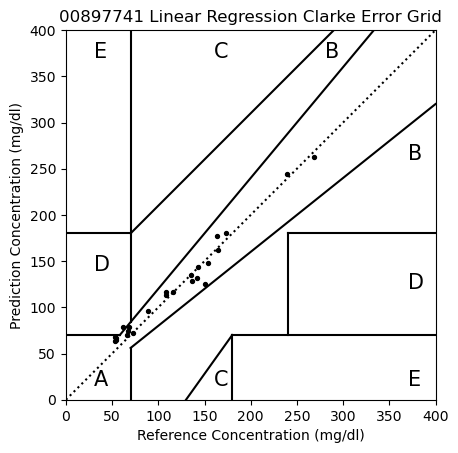

In [56]:
plot, zone = clarke_error_grid(df_glucose['Glucose level True'], df_glucose['Glucose level Predict'], "00897741 Linear Regression")
plot.show()

In [57]:
dfPlot=pd.DataFrame()
dfPlot['y_true']=df_glucose['Glucose level True']
dfPlot['y_pred']=df_glucose['Glucose level Predict']
dfPlot.index=pd.date_range("2023-01-01", periods=len(df_glucose['Glucose level True']), freq="15min")
dfPlot

,y_true,y_pred
2023-01-01 00:00:00,54.0,64.240288
2023-01-01 00:15:00,116.0,117.121422
2023-01-01 00:30:00,136.0,128.452118
2023-01-01 00:45:00,53.0,63.159054
2023-01-01 01:00:00,143.0,143.405396
2023-01-01 01:15:00,165.0,161.996536
2023-01-01 01:30:00,135.0,135.422516
2023-01-01 01:45:00,173.0,180.737793
2023-01-01 02:00:00,239.0,244.510468
2023-01-01 02:15:00,108.0,116.517418


AP, BE, EP: (0.9565217391304348, 0.0, 0.043478260869565216)


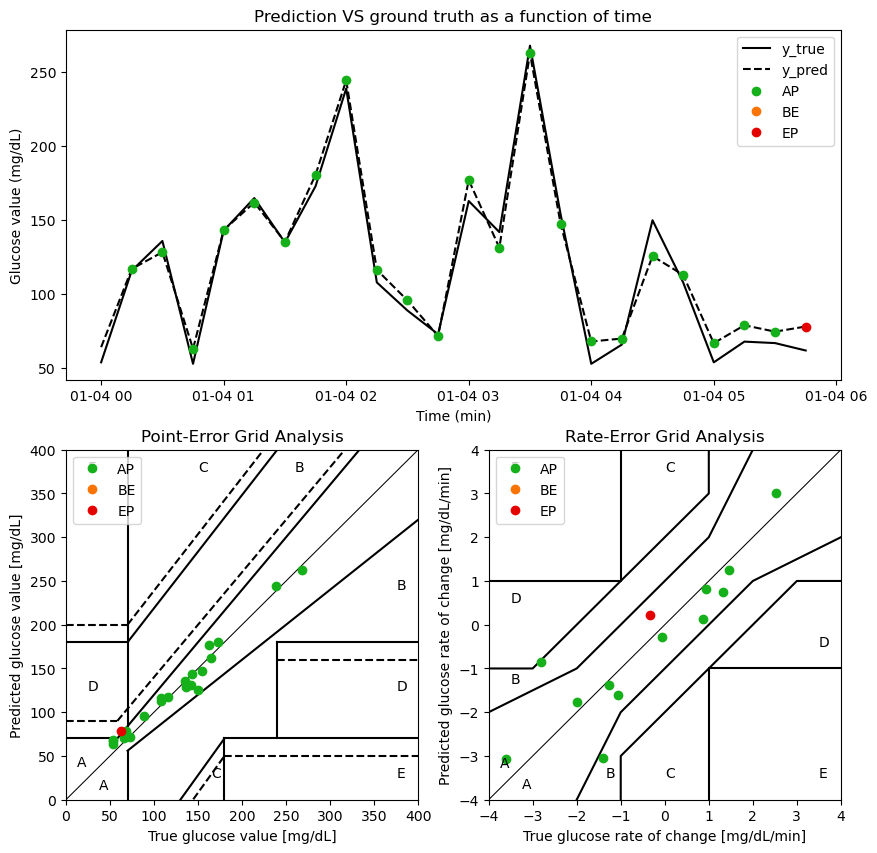

In [58]:
freq = 15
cg_ega = CG_EGA(dfPlot, freq)
print("AP, BE, EP:", cg_ega.reduced())
cg_ega.plot(day=0)

In [59]:
results

NameError: name 'results' is not defined